# Addressing text classification as a Graph classification problem using GNNs

This notebook has the objective of guiding developers through the cast of text classification, the most common NLP task, as a graph classification problem. <br>
<br>
In particular, by considering sentences as a sequence of words, each with an associated embedding, connected with eachother through means of sintactic relationships, we can model the formers as 
graphs and proceed to classificate them. 
<br>
<br>
In this work we decided to consider GloVe embeddings as the embeddings of the words, since they are not context dependant, the information about sequentiality is kept by adding edges between consecutive words, in the graph representing the sentence.
<br>
Since the objective is to understand how the problem could be tackled, 
we decided to keep training recipes as simple as possible, as the focus is shifted towards the representation of the data and how it is handled by GNNs. 


## About the Dataset

We decided to perform text classification on a dataset of tweets related to Covid-19, where the target feature is a sentiment expressed by the tweet in relation to the pandemic, we list below the domain of the target feature as well as some associated examples: <br>
- Extremely Positive sentiment: "We thank you for your patience during this time" <br>
- Positive sentiment: "I've been following social distancing rules and staying home to prevent the spread of you.  However, now I've spent an alarming amount of money shopping online.  Where can I submit my expenses to for reimbursement? Let me know."
- Neutral sentiment: "The COVID-19 coronavirus pandemic is impacting consumer shopping behavior, purchase decisions and retail sales, according to a First Insight study."
- Negative sentiment: "what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checkout staff to police the actions of the selfish and profiteer"
- Extremely negative sentiment: "Not because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage..."
<br>

The decision to consider this dataset was took for three practical reasons:
- It consists in a huge amount of entries (more than 41k tweets only in the training set)
considering that everything should run on Google Colab
- Only a few words can be used to discriminate between classes, appropriate enough since the objective is to check wether injecting structural information can be an effective strategy to automatically learn embeddings that give more value to the most important terms
- Since the dataset is on kaggle, we will have the possibility to compare our approach to other relevant approaches often used in literature, such as BERT fine-tuning

<br>

The kaggle web page related to the dataset can be found here: <br>
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

## Required external libraries

The problem of casting text classification as graph classification is handled with:
- Stanza, a Natural Language Analysis tool, essentially the evolution of NLTK,
this will be needed in order to tokenize sentences and perform the dependency parsing, as will be shown below, we are actually working on tree structure with a small variant: only a single node will have a link to himself and it is node "0", the one that should represent the whole sentence wich has an in-link with the main verb. For more informations about Stanza it is possible to visit the official website: <br> https://stanfordnlp.github.io/stanza/
- Graphviz, an open-source tool to visualize graphs, it will be useful to understand what outputs are provided by the dependency parser and what we are actually feeding to our GNNs. The complete documentation can be found in the official website:<br> https://graphviz.org/
- pre-trained GloVe embeddings, which can be downloaded here: <br>
https://nlp.stanford.edu/projects/glove/
- Pytorch Geometric, it is the library to handle Graph Neural Networks, it will be used to build our GNNs as well as constructing, saving and loading the final, processed dataset of graphs. The documentation can be found here:<br>
https://pytorch-geometric.readthedocs.io/en/latest/

In [2]:
# download of the libraries
!pip install graphviz
!pip install stanza
!pip install transformers
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.7/353.7 kB 31.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.4.0-py2.py3-none-any.whl size=350809 sha256=db530cde7d24edd2bab0defd0318a1cb92b6ee5b5b24a4c3279103d270de8fdc
  Stored in directory: /root/.cache/pip/wheels/79/29/1c/234cae4632803c2ba4a76a71a679eb1383cf590775714e2a21
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 M

In [3]:
# import of the libraries
import numpy as np
import os
import os.path as osp
import shutil

import stanza

from graphviz import Source

from transformers import AutoTokenizer, BertModel

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

import torch
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset
from torch_geometric.utils import scatter
from torch_geometric.data import download_url
from torch_geometric.nn import GCNConv, GATv2Conv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch.optim.lr_scheduler import StepLR

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

import pickle
import copy
import re
from functools import partial

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# initialization of the stanza pipeline to get dependency graphs
# be sure to execute the notebook with gpu hardware acceleration
stanza.download("en")
nlp = stanza.Pipeline('en', use_gpu = True)

INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| sentiment    | sstplus   |
| ner          | ontonotes |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


# Dependency scheme
The sentence below is parsed so that a dependency graph is built in the
following way:
- Each word is associated to an index in [1, num_words]
- Each word has an outlink (head index) to the part of speech to wich it refers
- The word with head index equal to 0 is the govenor word, most of the times it is the main verb, but in this example it is the word "example"
- The other parts of speech have head index > 1 and are connected to eachother according to the Universal Dependencies scheme.
- Since no token in the sentence has index 0, it will have a "special" embedding in our graph representation
<br>

More informations can be found here: <br>
https://universaldependencies.org/introduction.html

In [ ]:
%%time
def print_example(example_sentence):
  nlp_example_sentence = nlp(example_sentence)
  to_print = []
  for sentence in nlp_example_sentence.sentences:
    cur_str = ""
    for word in sentence.words:
      if len(word.text) < 2:
        # we add an additional tabulation if the word is shorter than 2 characters
        cur_str = f"id: {word.id}\tword: {word.text}\t\t\thead id: {word.head}" 
      elif len(word.text) >= 10:
        # we remove a tabulation
        cur_str = f"id: {word.id}\tword: {word.text}\thead id: {word.head}"
      else:
        cur_str = f"id: {word.id}\tword: {word.text}\t\thead id: {word.head}"
      to_print.append(cur_str)
  for elem in to_print:
    print(elem)

print_example("This is an example needed to understand how the dependency parser, from the Stanza library, works.")

id: 1	word: This		head id: 4
id: 2	word: is		head id: 4
id: 3	word: an		head id: 4
id: 4	word: example		head id: 0
id: 5	word: needed		head id: 4
id: 6	word: to		head id: 7
id: 7	word: understand	head id: 5
id: 8	word: how		head id: 18
id: 9	word: the		head id: 11
id: 10	word: dependency	head id: 11
id: 11	word: parser		head id: 18
id: 12	word: ,			head id: 11
id: 13	word: from		head id: 16
id: 14	word: the		head id: 16
id: 15	word: Stanza		head id: 16
id: 16	word: library		head id: 11
id: 17	word: ,			head id: 11
id: 18	word: works		head id: 7
id: 19	word: .			head id: 4
CPU times: total: 11.7 s
Wall time: 13.3 s


## Note well
Since the output of the Stanza pipeline to create dependency graphs can consider more sentences at once, we have to create a dictionary where:
- the keys are strings in the format "{idx} tokens" or "{idx} dependency", where idx is the index of the sentece ("0 tokens" is the key for the list of tokens of the first sentence, "1 dependency" is the key for the list of dependencies, namely the edges of the dependency graph, for the second sentence)
- the values can be either lists of tokens or list of dependencies in the COO format, a common notation for sparse matrices:<br>
https://scipy-lectures.org/advanced/scipy_sparse/coo_matrix.html

In [26]:
# function for the construction of the dictionary containing tokens and
# dependencies
def get_tokens_and_dependencies(to_tokenize):
  nlp_dep = nlp(to_tokenize)
  to_return = {}
  for idx, sentence in enumerate(nlp_dep.sentences):
    token_list = np.array([])
    heads_arr = np.array([], dtype=np.int32)
    for word in sentence.words:
      token_list = np.append(token_list, word.text)
      heads_arr = np.append(heads_arr, word.head) 
    starting_nodes = np.arange(1, heads_arr.shape[0] + 1)
    dependency_arr = add_positional_links(starting_nodes, heads_arr)
    to_return.update({f"{idx} tokens": token_list, f"{idx} dependency":dependency_arr})
  return to_return

def add_positional_links(starting_nodes, heads_arr):
    num_nodes = starting_nodes.shape[0] - 1
    for i in range(1, num_nodes):
        if i + 1 != num_nodes:
            starting_nodes = np.append(starting_nodes, i)
            heads_arr = np.append(heads_arr, i + 1)
            starting_nodes = np.append(starting_nodes, i + 1)
            heads_arr = np.append(heads_arr, i)
    to_return = np.vstack((starting_nodes, heads_arr))
    return to_return

In [ ]:
# output example
returned_dict = get_tokens_and_dependencies("My babe don't stand no cheating, of course she will believe me. Oh yes, she don't stand no cheating")
print(returned_dict["0 tokens"])
print(returned_dict["0 dependency"])
print(returned_dict["1 tokens"])
print(returned_dict["1 dependency"])

['My' 'babe' 'do' "n't" 'stand' 'no' 'cheating' ',' 'of' 'course' 'she'
 'will' 'believe' 'me' '.']
[[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  1  2  2  3  3  4  4  5  5
   6  6  7  7  8  8  9  9 10 10 11 11 12 12 13]
 [ 2  5  5  5  0  7  5  5 13  9 13 13  5 13  5  2  1  3  2  4  3  5  4  6
   5  7  6  8  7  9  8 10  9 11 10 12 11 13 12]]
['Oh' 'yes' ',' 'she' 'do' "n't" 'stand' 'no' 'cheating']
[[1 2 3 4 5 6 7 8 9 1 2 2 3 3 4 4 5 5 6 6 7]
 [7 7 2 7 7 7 0 9 7 2 1 3 2 4 3 5 4 6 5 7 6]]


In [ ]:
class GloveUtils:
    def __init__(self, glove_path):
        self.glove_path = glove_path
        self.vocabulary = {}
        self.embeddings_dict = {}
        self.pca = PCA(n_components=3)
        
        self.max_proj = 0
        self.min_proj = 0
        
        with open(glove_path, 'r', encoding="utf-8") as f:
          for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            self.embeddings_dict[word] = vector
            
    def embed_to_GloVe(self, tokens_to_embed, pca_flag = False):
      # Initialize an empty list to store the embeddings
      embeddings = []

      # Iterate through the tokens and retrieve the embeddings
      for token in tokens_to_embed:
          if token in self.embeddings_dict:
              embeddings.append(self.embeddings_dict[token])
              self.vocabulary.update({token:self.embeddings_dict[token]})
          else:
            # If the token is not found in the vocabulary, you can assign a random embedding or any other handling strategy
            random_embed = np.random.uniform(-0.25, 0.25, 50)
            embeddings.append(random_embed)
            self.vocabulary.update({token:random_embed})

      # Convert the list of embeddings to a NumPy array
      if pca_flag:
          self.__fit_pca__()
      embeddings = np.array(embeddings)
      return embeddings
    
    def __fit_pca__(self):
        to_fit = [self.vocabulary[word] for word in list(self.vocabulary.keys())]
        fitted_vocab = self.pca.fit_transform(to_fit)
        self.max_proj = np.amax(fitted_vocab)
        self.min_proj = np.amin(fitted_vocab)
    
    def project_embedding(self, embed_to_project):
        #self.__fit_pca__()
        projected_embed = self.pca.transform(np.array([embed_to_project]))
        to_return = (projected_embed - self.min_proj) / (self.max_proj - self.min_proj)
        return to_return
    
    def project_embeddings(self, embeddings):
        projected_embed = self.pca.transform(embeddings)
        to_return = (projected_embed - self.min_proj) / (self.max_proj - self.min_proj)
        return to_return
    
    def project_tokens(self, tokens_to_project):
        n_tok = len(tokens_to_project)
        embeddings = self.embed_to_GloVe(tokens_to_project)
        to_return = np.zeros((n_tok, 3))
        for i in range(0, n_tok):
            to_return[i, :] = self.project_embedding(embeddings[i, :])
        return to_return
    
    def serialize_vocab(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.vocabulary, f)
        
    def load_vocab(self, path):
        with open(path, 'rb') as f:
            self.vocabulary = pickle.load(f)

In [ ]:
glove_path = 'content/embed/glove.6B.50d.txt'
g_utils = GloveUtils(glove_path)
sentence = "I love natural language processing"
tokens = word_tokenize(sentence)
embeddings = g_utils.embed_to_GloVe(tokens, pca_flag = True)
#print(g_utils.vocabulary)
print(g_utils.project_tokens(["Antonio", "Pasquale", "Luigi", "The"]))
print(len(g_utils.vocabulary.keys()))

[[0.48306207 0.18088497 0.87061875]
 [0.46818058 0.18462235 0.8003757 ]
 [0.50053577 0.2292189  0.87463929]
 [0.47263093 0.17731894 0.83107477]]
9


In [ ]:
print(g_utils.vocabulary.keys())

dict_keys(['I', 'love', 'natural', 'language', 'processing', 'Antonio', 'Pasquale', 'Luigi', 'The'])


# Data objects

`torch_geometric` has its special way to define learnable graphs, called `Data`
objects along the whole documentation. At a low level of abstraction, they are essentially tuples in the form: <br>
`(feature_tensor, index_tensor, target_labels_tensor)`
Where:
- `feature_tensor` has shape `(num_nodes, num_features)`
- `index_tensor` has shape `(2, num_edges`) and type `torch.int64`, they express edges of a graph in the COO format shown above
- `target_labels_tensor` with arbitrary shape (it is the ground truth vector) 
<br>
<br>
With the function below, wich will become a method in our custom Dataset class,
we convert a single entry of the dataset in a Data object.


In [ ]:
from torch_geometric.data import Batch

def __build_graph_Data_with_GloVe__(sentence, y_val, return_tokens = False):  
      if return_tokens:
          token_list = []
      tok_dep_dict = get_tokens_and_dependencies(sentence)
      intra_sentence_data_list = []

      if len(tok_dep_dict.keys()) > 0:
        for i in range(0, len(tok_dep_dict.keys()) // 2):
          if return_tokens:
              token_list.extend(tok_dep_dict[f"{i} tokens"])
          glove_embeddings = torch.tensor(g_utils.embed_to_GloVe(tok_dep_dict[f"{i} tokens"]))
          glove_sentence_avg = torch.mean(glove_embeddings, dim=0)
          # the sentence is modelled as the directed dependency graph where the nodes
          # have the bert embeddings as features, since the verb of the main
          # sentence points to 0, node 0 has the pooler output as its features,
          # as they represent the meaning of the whole sentence 
          node_features = torch.vstack((glove_sentence_avg, glove_embeddings)) 
          edge_idxs = torch.tensor(tok_dep_dict[f"{i} dependency"], dtype = torch.int64)
          data = Data(x = node_features, edge_index = edge_idxs, y = y_val)
          intra_sentence_data_list.append(data)

        batch = Batch.from_data_list(intra_sentence_data_list)
        if return_tokens:
            return batch, token_list
        return batch

In [ ]:
temp_glove_graph, tokens = __build_graph_Data_with_GloVe__("I hope that this will work", 0, True)
print(temp_glove_graph)
print(tokens)

DataBatch(x=[7, 50], edge_index=[2, 12], y=[1], batch=[7], ptr=[2])
['I', 'hope', 'that', 'this', 'will', 'work']


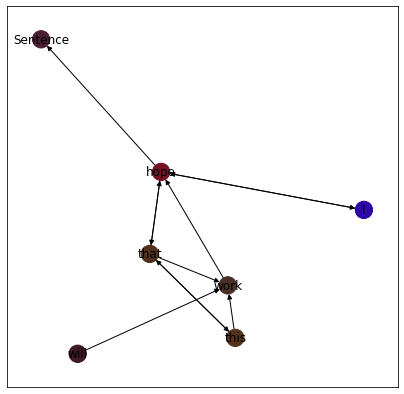

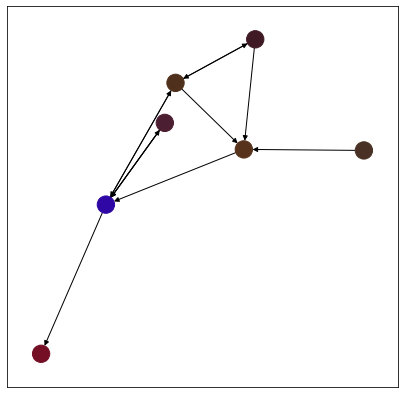

In [ ]:
# let us try to visualize this mess
# we should plot this graph with labels for each node that represent
# the corresponding word in the sentence or, for simplicity, 
# the node index corresponding to that word

from torch_geometric.utils import to_networkx

def visualize_graph(G, labels = []):
    to_draw = to_networkx(G, to_undirected = False)
    embeds = G["x"]
    embeds = embeds.cpu()
    n_nodes = embeds.shape[0]
    colors = np.power(g_utils.project_embeddings(embeds), 2)
    color = "red"
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    if labels == []:
        nx.draw_networkx(to_draw, pos=nx.spring_layout(to_draw, seed=42), with_labels=False,
                         node_color=colors, cmap="Set2")
    else:
        labels = dict(zip(np.arange(1, n_nodes), labels))
        labels.update({0:"Sentence"})
        nx.draw_networkx(to_draw, pos=nx.spring_layout(to_draw, seed=42), with_labels=True,
                         labels = labels,
                         node_color=colors, cmap="Set2")
    plt.show()
    
def visualize_hidden_graph(x_features, links, labels = [], project_flag = True):
    to_draw = nx.MultiDiGraph()
    links_for_the_net = list(zip(links[0, :].detach().cpu().numpy(), 
                                 links[1, :].detach().cpu().numpy()))
    to_draw.add_edges_from(links_for_the_net)
    embeds = x_features.detach().cpu()
    n_nodes = embeds.shape[0]
    if project_flag:
        colors = np.power(g_utils.project_embeddings(embeds), 2)
    else:
        colors = embeds # if embeds has a number of columns different from 3, some
                        # aggregation must be performed before calling this
                        # function with project_flag == False
    
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    if labels == []:
        nx.draw_networkx(to_draw, pos=nx.spring_layout(to_draw, seed=42), with_labels=False,
                         node_color=colors, cmap="Set2")
    else:
        labels = dict(zip(np.arange(1, n_nodes), labels))
        labels.update({0:"Sentence"})
        nx.draw_networkx(to_draw, pos=nx.spring_layout(to_draw, seed=42), with_labels=True,
                         labels = labels,
                         node_color=colors, cmap="Set2")
    plt.show()

#print(tweet_list_train[1])
#G = to_networkx(cv19_graph_data_train[1], to_undirected=False)
visualize_graph(temp_glove_graph, tokens)
x_features = temp_glove_graph.x
links = temp_glove_graph.edge_index
visualize_hidden_graph(x_features, links)

# Dataset Pre-processing and statistics

In [11]:
# the dataset that we are considering can be found here:
# https://www.kaggle.com/code/harshpriye/covid-tweets-sentiment-analysis

df=pd.read_csv("/content/Corona_NLP_train.csv", encoding='latin1')
df.head

<bound method NDFrame.head of        UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet           Sentiment  
0      @MeNyrb

In [ ]:
df.shape

(41157, 6)

In [ ]:
# checking for null values
overview=pd.concat([df.isnull().sum(),df.nunique()],axis=1,keys=['Null Counts','Cardinality'])
overview

,Null Counts,Cardinality
UserName,0,41157
ScreenName,0,41157
Location,8590,12220
TweetAt,0,30
OriginalTweet,0,41157
Sentiment,0,5


In [12]:
# Removing NULLS:
idx=df.loc[df.Location.isnull()].index
df_clean=df.drop(idx)
df_clean.shape

(32567, 6)

In [ ]:
overview=pd.concat([df_clean.isnull().sum(),df_clean.nunique()],axis=1,keys=['Null Counts','Cardinality'])
overview

,Null Counts,Cardinality
UserName,0,32567
ScreenName,0,32567
Location,0,12220
TweetAt,0,30
OriginalTweet,0,32567
Sentiment,0,5


In [13]:
# dropping columns
df.drop(columns=['UserName','ScreenName','Location','TweetAt'], inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
sentiments=df.Sentiment.value_counts()
sentiments

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

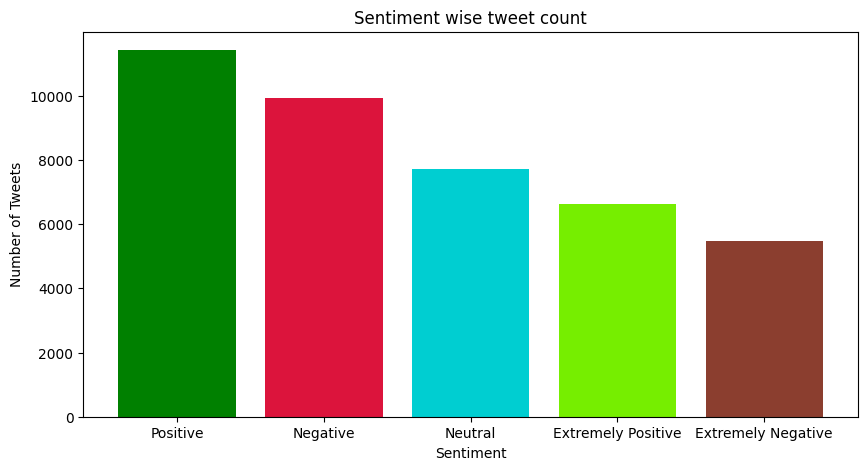

In [ ]:
plt.subplots(figsize=(10,5))
plt.bar(sentiments.index,sentiments.values, color=['green','#DC143C','#00CED1','#76EE00','#8B3E2F'])
plt.title("Sentiment wise tweet count")
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

<ipython-input-14-0e1d46418139>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
<ipython-input-14-0e1d46418139>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_lengths)


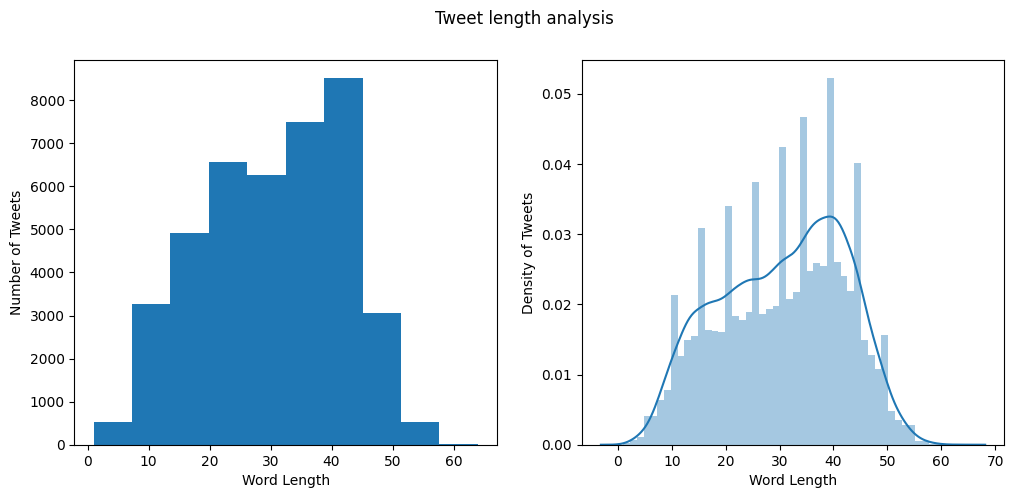

In [14]:
tweet_lengths = df['OriginalTweet'].apply(lambda x: len(x.split()))

plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(tweet_lengths)
plt.suptitle("Tweet length analysis")
plt.xlabel("Word Length")
plt.ylabel("Number of Tweets")

plt.subplot(1,2,2)
sns.distplot(tweet_lengths)
plt.xlabel("Word Length")
plt.ylabel("Density of Tweets")
plt.show()

In [15]:
# tweet cleaning
# tweets with a low number of tokens should be eliminated

def preprocessing(x):
    # helper functions:
    def remove_hashtags(text): return re.sub(r'#\w*', ' ' , text)
    def remove_mentions(text): return re.sub(r'@\w*', ' ' , text)
    def remove_urls(text): return re.sub(r'https?://\S+', ' ', text)
    def remove_apostrophe(text): return re.sub(r"'s\b", "", text)
    def remove_special_chars(text): return re.sub(r"[^a-zA-Z0-9\s]", ' ', text)
    def remove_numbers(text): return re.sub(r'[\d]', ' ', text)
    def remove_formatting_symbols(text): return re.sub(r"[\r\n]+",'',text)
    def remove_escape_characters(text): return re.sub(r"\\",'',text)
    def remove_extra_spaces(text): return re.sub(r"\s{2,}",' ',text)
    x=x.apply(remove_hashtags)
    x=x.apply(remove_mentions)
    x=x.apply(remove_urls)
    x=x.apply(remove_apostrophe)
    x=x.apply(remove_special_chars)
    x=x.apply(remove_numbers)
    x=x.apply(remove_formatting_symbols)
    x=x.apply(remove_escape_characters)
    x=x.apply(remove_extra_spaces)
    x=x.str.lower()
    return x

In [16]:
#%%time
df['OriginalTweet']=preprocessing(df['OriginalTweet'])
df

,OriginalTweet,Sentiment
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the outbr...,Extremely Negative
...,...,...
41152,airline pilots offering to stock supermarket s...,Neutral
41153,response to complaint not provided citing covi...,Extremely Negative
41154,you know it s getting tough when is rationing ...,Positive
41155,is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
# checking random tweet:
df.iloc[41153,0]

'response to complaint not provided citing covid related delays yet prompt in rejecting policy before consumer tat is over way to go '

In [17]:
# function to build sentiment wisewordcloud:
def show_wordcloud(df):
    sentiments=df.Sentiment.value_counts().index.to_list()
    
    stopwords = set(STOPWORDS)
    
    plt.subplots(figsize=(14,14))
    i=1
    for senti in sentiments:
        curr=df['OriginalTweet'].loc[df.Sentiment==senti]
        text=curr.values
        text=' '.join(text)
        
        wordcloud=WordCloud(max_words=100, stopwords=stopwords, background_color='white', max_font_size=50).generate(text)
        
        plt.subplot(3,2,i)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(senti,fontsize=15)
        i+=1

<ipython-input-17-2de648a3933a>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i)


CPU times: user 6.29 s, sys: 103 ms, total: 6.39 s
Wall time: 6.5 s


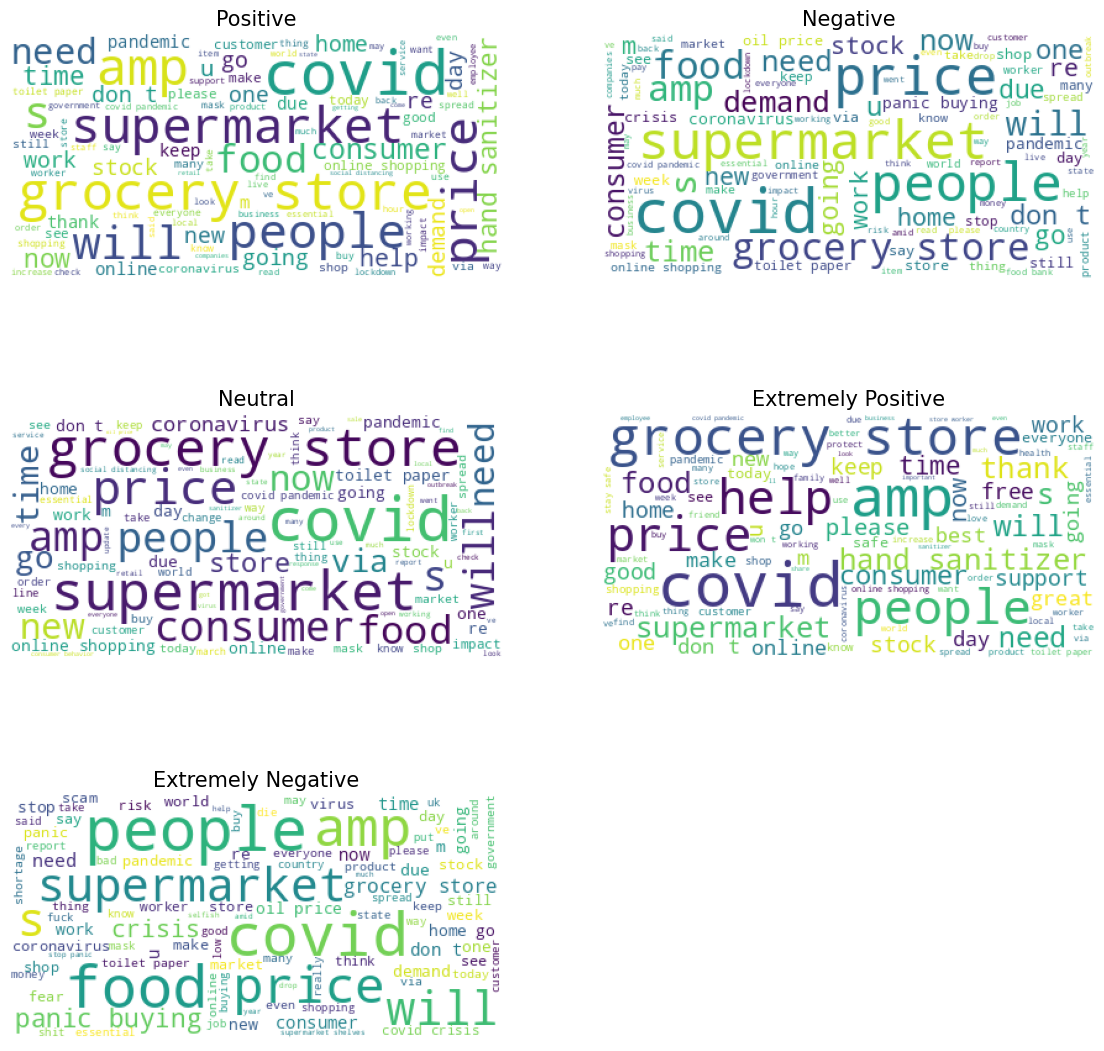

In [18]:
%%time
# generating wordclouds:
show_wordcloud(df)

In [19]:
# function for label reduction and encoding:
def label_preprocessing(labels):
    lab_dict={
        'Extremely Negative': 0,
        'Negative': 1,
        'Neutral': 2,
        'Positive': 3,
        'Extremely Positive': 4
    }
    labels=labels.map(lab_dict)
    
    return labels

In [20]:
#%%time
# label preprocessing:
df['Sentiment']=label_preprocessing(df['Sentiment'])
df

,OriginalTweet,Sentiment
0,and and,2
1,advice talk to your neighbours family to excha...,3
2,coronavirus australia woolworths to give elder...,3
3,my food stock is not the only one which is emp...,3
4,me ready to go at supermarket during the outbr...,0
...,...,...
41152,airline pilots offering to stock supermarket s...,2
41153,response to complaint not provided citing covi...,0
41154,you know it s getting tough when is rationing ...,3
41155,is it wrong that the smell of hand sanitizer i...,2


In [ ]:
senti=df['Sentiment'].value_counts()
senti

3    11422
1     9917
2     7713
4     6624
0     5481
Name: Sentiment, dtype: int64

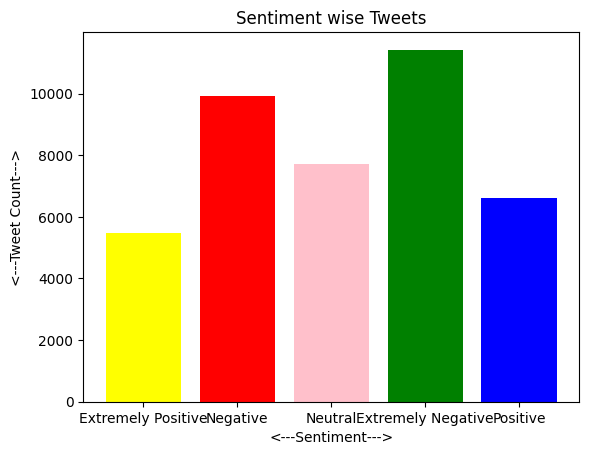

In [ ]:
# this must be plotted correctly, it is all wrong
plt.bar(senti.index, senti.values, color=['green','red','pink', 'blue', 'yellow'])
plt.xticks(senti.index, ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.title('Sentiment wise Tweets')
plt.xlabel('<---Sentiment--->')
plt.ylabel('<---Tweet Count--->')
plt.show()

In [21]:
def get_long_tweets(df, tweet_lengths):
    to_retrun = df.loc[tweet_lengths >= 20]
    return to_retrun

df_lengthy = get_long_tweets(df, tweet_lengths)
print(df_lengthy.shape)

(32435, 2)


In [22]:
df_to_use = df_lengthy#.iloc[100:3100]
df_to_use

,OriginalTweet,Sentiment
1,advice talk to your neighbours family to excha...,3
3,my food stock is not the only one which is emp...,3
4,me ready to go at supermarket during the outbr...,0
5,as news of the region s first confirmed covid ...,3
6,cashier at grocery store was sharing his insig...,3
...,...,...
41149,still shocked by the number of supermarket emp...,1
41150,i never that we d be in a situation amp world ...,3
41151,you are definitely my man i feel like this fa...,4
41153,response to complaint not provided citing covi...,0


In [23]:
df_to_use_tweet_list = df_to_use["OriginalTweet"]
tweet_list = df_to_use_tweet_list.to_list()


df_to_use_sentiments = df_to_use["Sentiment"]
sentiment_list = df_to_use_sentiments.to_list()

for index in range(0, len(tweet_list)):
  if tweet_list[index] == "":
    del tweet_list[index]
    del sentiment_list[index]

train_idx = int(len(tweet_list)*80 // 100) 

tweet_list_train = tweet_list[:train_idx]
tweet_list_val = tweet_list[train_idx:]
sentiment_list_train = sentiment_list[:train_idx]
sentiment_list_val = sentiment_list[train_idx:]

print(tweet_list_train[0])
print(sentiment_list_train[0])

advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order
3


In [24]:
print(np.unique(sentiment_list_train, return_counts = True))
print(np.unique(sentiment_list_val, return_counts = True))


(array([0, 1, 2, 3, 4]), array([4059, 6395, 3408, 7353, 4733]))
(array([0, 1, 2, 3, 4]), array([ 829, 1482,  912, 1910, 1354]))


In [7]:
from google.colab import auth
auth.authenticate_user()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.listdir("/content/drive/MyDrive/GraphDataset/train/"))

[]


# What to feed to the networks?

It is important to note that computing the above mentioned graph structure
for each entry of the dataset is costly in terms of time, given the large amount
of entries, thus a pre-computed version of the dataset can be uploaded to Google drive.
By calling the constructor of the class `Dataset_from_sentences`, the dataset in the corresponding drive folder will be loaded in Colab and also in memory, ready for training.

In [39]:
# class containing the graph data that must be fed into the GCNs or GAT networks
class Dataset_from_sentences(Dataset):
    def __init__(self, name, path_were_save, drive_dir, sentences_list, y_values, transform=None):
      self.name = name
      self.drive_dir = drive_dir
      self.root = path_were_save
      self.raw_url = str(self.drive_dir + self.name + ".pt")
      print(self.raw_paths)
      self.data_list = []
      self.sentences_list = sentences_list
      self.y_values = y_values
      super().__init__(path_were_save, transform)
      if os.path.exists(self.raw_paths[0]):
        self.data_list = torch.load(self.raw_paths[0])
      else:
        print("something strange happened")
        

    @property
    def processed_file_names(self):
      return self.raw_paths[0]

    @property 
    def raw_paths(self):
      to_return = self.root + "/" + self.name + ".pt"
      return [to_return]
      

    def download(self):
      if os.path.exists(self.raw_url):
        shutil.copy(self.raw_url, self.raw_paths[0])
      else:
        pass


    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

    def __build_graph_Data_with_GloVe__(self, sentence, y_val):  
      tok_dep_dict = get_tokens_and_dependencies(sentence)
      intra_sentence_data_list = []
      if len(tok_dep_dict.keys()) > 0:
        for i in range(0, len(tok_dep_dict.keys()) // 2):
          glove_embeddings = torch.tensor(g_utils.embed_to_GloVe(tok_dep_dict[f"{i} tokens"]))
          glove_sentence_avg = torch.mean(glove_embeddings, dim=0)
          # the sentence is modelled as the directed dependency graph where the nodes
          # have the bert embeddings as features, since the verb of the main
          # sentence points to 0, node 0 has the pooler output as its features,
          # as they represent the meaning of the whole sentence 
          node_features = torch.vstack((glove_sentence_avg, glove_embeddings)) 
          edge_idxs = torch.tensor(tok_dep_dict[f"{i} dependency"], dtype = torch.int64)
          data = Data(x = node_features.float(), edge_index = edge_idxs, y = y_val)
          intra_sentence_data_list.append(data)

        batch = Batch.from_data_list(intra_sentence_data_list)
        return batch
    

    def to(self, device):
      self.data_list.to(device)
      return self

     def process(self):
      num_invalid = 0
      for idx, elem in tqdm(enumerate(self.sentences_list)):
        #dataset_name = f"data_{idx - num_invalid}.pt"
        to_save = self.__build_graph_Data_with_GloVe__(elem, self.y_values[idx])
        if to_save is not None:
          self.data_list.append(to_save)
        else:
          num_invalid += 1
      torch.save(Batch.from_data_list(self.data_list), self.raw_paths[0])
      torch.save(Batch.from_data_list(self.data_list), self.raw_url)


In [ ]:
# function needed to clear a directory, it is necessary to call this function
# if some modifications to the dataset must be performed
def delete_processed_files(directory):
  if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
              for elem in os.listdir(file_path):
                os.unlink(osp.join(file_path, elem))
              os.rmdir(file_path)
        except Exception as e:
            print('Cannot eliminate {}: {}'.format(file_path, e))
    print(f"Now {directory} is empty")
  else:
      print("The directory does not exist")

In [ ]:
delete_processed_files("content/processed_train/")
delete_processed_files("content/drive/MyDrive/GraphDataset/train")

delete_processed_files("content/processed_val/")
delete_processed_files("content/drive/MyDrive/GraphDataset/val")

Now content/processed_train/ is empty
Now content/drive/MyDrive/GraphDataset/train is empty
Now content/processed_val/ is empty
Now content/drive/MyDrive/GraphDataset/val is empty


In [40]:
# construction of the training dataset
cv19_graph_data_train = Dataset_from_sentences("train", "/content/processed_train/", "/content/drive/MyDrive/GraphDataset/train/", tweet_list_train, sentiment_list_train)
cv19_graph_data_val = Dataset_from_sentences("validation", "/content/processed_val/", "/content/drive/MyDrive/GraphDataset/val/", tweet_list_val, sentiment_list_val)

['/content/processed_train//train.pt']
['/content/processed_val//validation.pt']


In [ ]:
g_utils.serialize_vocab("content/embed/glove_utils_object.pkl")

In [ ]:
g_utils.load_vocab("content/embed/glove_utils_object.pkl")

In [ ]:
print(cv19_graph_data_train.data_list)

DataBatch(x=[804513, 50], edge_index=[2, 2206026], y=[23057], batch=[804513])


In [41]:
print(len(cv19_graph_data_train))
print(cv19_graph_data_train.num_node_features)
print(cv19_graph_data_train[0]["x"].dtype)
print(cv19_graph_data_train.data_list.y)

23057
50
torch.float32
tensor([3, 3, 0,  ..., 3, 0, 0])


In [42]:
# Stratified K-fold Cross Validation to get stratified train-test splits

skf = StratifiedKFold(n_splits = 8)
fold_train_list = []
fold_val_list = []
print(len(cv19_graph_data_train))
for i, (train_idx, val_idx) in enumerate(skf.split(cv19_graph_data_train, 
                                                   cv19_graph_data_train.data_list.y.cpu())):
    fold_train_list.append(cv19_graph_data_train[list(train_idx)])
    fold_val_list.append(cv19_graph_data_train[list(val_idx)])
    
strat_train = fold_train_list[0]
strat_val = fold_val_list[0]
print(strat_train, strat_val)

23057
Dataset_from_sentences(20174) Dataset_from_sentences(2883)


In [ ]:
help(DataLoader)

Help on class DataLoader in module torch_geometric.loader.dataloader:

class DataLoader(torch.utils.data.dataloader.DataLoader)
 |  DataLoader(dataset: Union[torch_geometric.data.dataset.Dataset, Sequence[torch_geometric.data.data.BaseData], torch_geometric.data.datapipes.DatasetAdapter], batch_size: int = 1, shuffle: bool = False, follow_batch: Optional[List[str]] = None, exclude_keys: Optional[List[str]] = None, **kwargs)
 |  
 |  A data loader which merges data objects from a
 |  :class:`torch_geometric.data.Dataset` to a mini-batch.
 |  Data objects can be either of type :class:`~torch_geometric.data.Data` or
 |  :class:`~torch_geometric.data.HeteroData`.
 |  
 |  Args:
 |      dataset (Dataset): The dataset from which to load the data.
 |      batch_size (int, optional): How many samples per batch to load.
 |          (default: :obj:`1`)
 |      shuffle (bool, optional): If set to :obj:`True`, the data will be
 |          reshuffled at every epoch. (default: :obj:`False`)
 |      

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


print("Data built from list of sentences:\n " + str(cv19_graph_data_train))

data = cv19_graph_data_train.to(device)
print(data[0].x.get_device())
# apparently, with the "to" method we are modifying the
# elements of the inner list "data_list", accessing the elements of 
# that list without the ".data_list" notation
# returns tensors that are on the device in the case of the features of the nodes
# while it returns tensors that are on cpu for the attribute "edge_index" and "y"
# this really makes me confused, but using the ".data_list" notation solves the problem
print(data.data_list[0].edge_index.get_device()) 
print(data.data_list[0].y.get_device())
print("________________________________")

loader =  DataLoader(cv19_graph_data_train.data_list, batch_size=10, shuffle=True)
print(f"length of the loader is {len(loader)}")

for batch in loader:
  # each minibatch is again a Data object 
  print("The current batch is the following object:\n " + str(batch))
  print("The number of graphs in the current batch is:\n " + str(batch.num_graphs))
  print("The number of nodes for this batch is: \n" + str(batch.x.shape))
  print(batch.x.device)
  print("The edge indexes for the current batch are:\n " + str(batch.edge_index.shape))
  print(batch.edge_index.device)
  print(batch.edge_index)
  print(batch.edge_index.shape[1] in batch.edge_index)
  print("The ground truth vector is:\n " + str(batch.y))
  print(batch.y.device)

  for i in range(0, batch.num_graphs):
    print("__________AAA__________")
    print(f"elem {i}:")
    print("nodes shape:\n " + str(batch[i].x.shape))
    print("edges idxs for the current sample:\n " + str(batch[i].edge_index))
    print("ground truth shape:\n " + str(batch[i].y.shape))

  # batch is a column vector that maps each node to its respective 
  # graph in the batch, it can be accessed with ".batch" and can 
  # be used to aggregate features of each nodes for each individual graph
  x = scatter(batch.x, batch.batch, dim = 0, reduce = "mean")
 
  print(batch.x.shape) 
  
  print(x.shape)
  break

<IPython.core.display.Javascript object>

Data built from list of sentences:
 Dataset_from_sentences(23057)
0
0
0
________________________________
length of the loader is 2306
The current batch is the following object:
 DataBatch(x=[284, 50], edge_index=[2, 762], y=[10], batch=[284], ptr=[11])
The number of graphs in the current batch is:
 10
The number of nodes for this batch is: 
torch.Size([284, 50])
cuda:0
The edge indexes for the current batch are:
 torch.Size([2, 762])
cuda:0
tensor([[  1,   2,   3,  ..., 280, 280, 281],
        [  2,   0,   5,  ..., 279, 281, 280]], device='cuda:0')
False
The ground truth vector is:
 tensor([3, 4, 1, 0, 0, 0, 3, 1, 1, 2], device='cuda:0')
cuda:0
__________AAA__________
elem 0:
nodes shape:
 torch.Size([35, 50])
edges idxs for the current sample:
 tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,  1,  2,
          2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11,
 

edges idxs for the current sample:
 tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
          9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17,
         18, 18, 19],
        [ 3,  3,  6,  6,  6,  0,  8,  6,  6, 11,  6, 13, 11, 16, 16, 13, 21, 21,
         21, 21, 13,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,
          8, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18,
         17, 19, 18]], device='cuda:0')
ground truth shape:
 torch.Size([1])
torch.Size([284, 50])
torch.Size([10, 50])


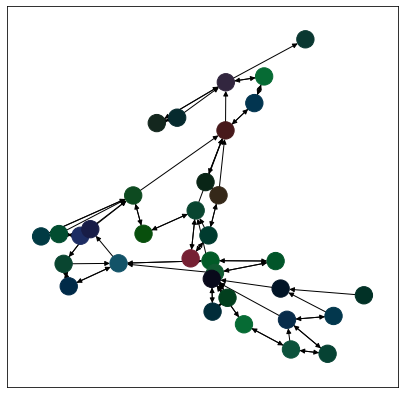

In [ ]:
visualize_graph(cv19_graph_data_train[1])

In [ ]:
# here we should plot some statistics about the graphs
avg_node_deg = 0

i = 0
for elem in cv19_graph_data_train:
  avg_node_deg += elem.num_edges / elem.num_nodes
  i += 1

print(f'Average node degree: {avg_node_deg:.2f}')

Average node degree: 2186.38


In [43]:
batch_size = 10

import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import PolynomialLR
from torch_geometric.nn.pool import global_max_pool
from torch.optim.lr_scheduler import OneCycleLR

# GCN definition
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, n_filters, dim_out):
    super().__init__()
    # dim_in is the number of node features, dim_h is the dimension
    # of the hidden layer, dim_out is the dimension of the output
    # feature vector
    
    self.gcn_list = torch.nn.ModuleList([GCNConv(dim_in, dim_in // 2, add_self_loops = True)
                                         for i in range(0, n_filters)])

    self.softmax = nn.Softmax(dim=1)
    self.l_list = torch.nn.ModuleList([Linear(dim_in // 2, 1)              
                                      for i in range(0, n_filters)])
    self.bn = torch.nn.BatchNorm1d(n_filters)#* n_filters)
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    if enable_log:
        visualize_hidden_graph(x, edge_index)
    
    h_list = []
    for i, gcn_l in enumerate(self.gcn_list):
        h = gcn_l(x, edge_index)
        h = h.tanh()
        if enable_log:
            print("h shape: " + str(h.shape))
            visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)
    
    h_layers = torch.hstack(h_list)
    h_layers = self.softmax(h_layers)
    h_layers = self.bn(h_layers)
    h_layers = self.classifier(h_layers)
    return h_layers
    

# actual GAT class
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, n_filters, dim_out, heads= 8):
    super().__init__()
    # dim_in is the number of node features, dim_h is the dimension
    # of the hidden layer, dim_out is the dimension of the output
    # feature vector
    
    self.gat_list = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // 2, heads = heads)
                                         for i in range(0, n_filters)])

    self.softmax = nn.Softmax(dim=1)
    self.l_list = torch.nn.ModuleList([Linear(dim_in // 2 * heads, 1)              
                                      for i in range(0, n_filters)])
    self.bn = torch.nn.BatchNorm1d(n_filters)
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    if enable_log:
        visualize_hidden_graph(x, edge_index)
    
    h_list = []
    for i, gat_l in enumerate(self.gat_list):
        h = gat_l(x, edge_index)
        h = h.tanh()
        if enable_log:
            print("h shape: " + str(h.shape))
            visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)
    
    h_layers = torch.hstack(h_list)
    h_layers = self.softmax(h_layers)
    h_layers = self.bn(h_layers)
    h_layers = self.classifier(h_layers)
    return h_layers

class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over the course of training.
    Args:
        train_losses: A list of training losses.
        val_losses: A list of validation losses.
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [44]:
def train(model, strat_train, strat_val, partial_scheduler, epochs = 30, print_every = 1):
    """Train a GNN model and return the trained model."""
    # thank god I don't have to onehot encode the labels
    batch_size = 10
    criterion = torch.nn.CrossEntropyLoss(label_smoothing = 0.01) 
    optimizer = model.optimizer
    scheduler = partial_scheduler(optimizer)
    loader_train =  DataLoader(strat_train.data_list, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(strat_val.data_list, batch_size=batch_size, shuffle=True)
    model.train()
    early_stopper = EarlyStopper(patience=10, min_delta=0.2)

    train_losses = []
    val_losses = []
    
    best_model = []
    best_acc_val = 0
    epochs_to_return = 0
    
    #scheduler.step()
    for epoch in range(epochs+1):
      mean_loss_train = 0
      mean_acc_train = 0
      for i, batch in enumerate(loader_train):
        # Training
        out = model(batch.x, batch.edge_index, batch.batch)
        loss_train = criterion(out, batch.y.long())
        mean_loss_train += loss_train.item()
        #print("loss for minibatch: " + str(i)+ "/" + str(len(loader_train)) + "is: " + str(loss_train))
        
        acc_train = accuracy(out.argmax(dim=1), batch.y)
        mean_acc_train += acc_train
        loss_train.backward()
        with torch.no_grad():
            optimizer.step() 
            optimizer.zero_grad()
        #optimizer.step()
      mean_loss_train /= i
      mean_acc_train /= i
      train_losses.append(mean_loss_train) 
      scheduler.step()
    
      mean_loss_val = 0
      mean_acc_val = 0
      with torch.no_grad():
          for i, batch in enumerate(loader_val):
            out = model(batch.x, batch.edge_index, batch.batch)
            loss_val = criterion(out, batch.y.long())
            mean_loss_val += loss_val.item()
            acc_val = accuracy(out.argmax(dim=1), batch.y)
            mean_acc_val += acc_val
            #visualize_embedding(embed, batch.y, epoch, loss_val)
          mean_loss_val /= i
          mean_acc_val /= i
          val_losses.append(mean_loss_val)
          if mean_acc_val > best_acc_val:
                best_acc_val = mean_acc_val
                best_model = copy.deepcopy(model)
                epochs_to_return = epoch
            
      if(epoch % print_every == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {mean_loss_train:.3f} | Train Acc: '
              f'{mean_acc_train*100:>6.2f}%')
        print(f'Epoch {epoch:>3} | Val Loss: {mean_loss_val:.3f} | Val Acc: '
              f'{mean_acc_val*100:>6.2f}%')
        print("learning rate: " + str(scheduler.get_lr()))
      if early_stopper.early_stop(mean_loss_val):
        print("early stopping was triggered, final loss:" + str(mean_loss_val))
        break
    plot_losses(train_losses, val_losses)
    return best_model, best_acc_val, epochs_to_return

In [45]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def build_scheduler_list(epochs = 30, max_lr = 1e-3):
    schedulers = []
    schedulers += [partial(PolynomialLR,
                         total_iters = epochs, # The number of steps that the scheduler decays the learning rate.
                         power = i) for i in range(1, 3)] # The power of the polynomial.
    schedulers += [partial(StepLR,
                                  step_size=epochs//i, gamma=0.5) for i in range(2, 9)]
    schedulers += [partial(CosineAnnealingLR,
                              T_max = epochs, # Maximum number of iterations.
                              eta_min = min_lr) for min_lr in [1e-6, 1e-7, 1e-8]]# Minimum learning rate
    
    schedulers += [partial(OneCycleLR,
                       max_lr = max_lr, # Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch = epochs//i, # The number of steps per epoch to train for.
                       epochs = epochs, # The number of epochs to train for.
                       anneal_strategy = 'cos') for i in range(2, 9)] # Specifies the annealing strategy
    return schedulers

In [46]:
def hyperparameter_tuning(model, strat_train, strat_val, scheduler_list, epochs = 30):
    best_valid_acc = 0
    best_model = []
    best_hyper_params = []
    best_val_acc = 0
    for partial_scheduler in scheduler_list:
        model_out, mean_acc_val, epoch = train(copy.deepcopy(model), strat_train, strat_val, 
                                               partial_scheduler, epochs, print_every=1)
        if mean_acc_val > best_val_acc:
            best_val_acc = mean_acc_val
            best_model = model_out
            best_hyper_params = [partial_scheduler, epoch]
            print(f"Improved result: acc {best_val_acc:.3f}, scheduler:\n {partial_scheduler}\nepoch: {epoch}")
    return best_hyper_params, best_model

In [49]:
model_gcn = GCN(cv19_graph_data_train.num_node_features, 
                cv19_graph_data_train.num_classes*2, 
                cv19_graph_data_train.num_classes).to(device)
print(model_gcn)

GCN(
  (gcn_list): ModuleList(
    (0-9): 10 x GCNConv(50, 25)
  )
  (softmax): Softmax(dim=1)
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=25, out_features=1, bias=True)
  )
  (bn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


In [51]:
#data_train = cv19_graph_data_train.to(device)
#data_val = cv19_graph_data_val.to(device)

strat_train = strat_train.to(device)
strat_val = strat_val.to(device)

In [50]:
print(get_lr(model_gcn.optimizer))
scheduler_list = build_scheduler_list()
print(scheduler_list)

0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=1), functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=15, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=10, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=7, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=6, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=5, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=4, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=3, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=30, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=30, eta_min=1e-07), functoo

Epoch   0 | Train Loss: 1.424 | Train Acc:  36.67%
Epoch   0 | Val Loss: 1.389 | Val Acc:  38.50%
learning rate: [0.0009344444444444444]
Epoch   1 | Train Loss: 1.379 | Train Acc:  39.25%
Epoch   1 | Val Loss: 1.359 | Val Acc:  40.21%
learning rate: [0.0009011494252873565]
Epoch   2 | Train Loss: 1.353 | Train Acc:  40.58%
Epoch   2 | Val Loss: 1.340 | Val Acc:  41.16%
learning rate: [0.000867857142857143]
Epoch   3 | Train Loss: 1.337 | Train Acc:  41.45%
Epoch   3 | Val Loss: 1.327 | Val Acc:  41.65%
learning rate: [0.0008345679012345681]
Epoch   4 | Train Loss: 1.324 | Train Acc:  42.32%
Epoch   4 | Val Loss: 1.307 | Val Acc:  43.03%
learning rate: [0.0008012820512820515]
Epoch   5 | Train Loss: 1.316 | Train Acc:  43.42%
Epoch   5 | Val Loss: 1.305 | Val Acc:  42.99%
learning rate: [0.0007680000000000001]
Epoch   6 | Train Loss: 1.308 | Train Acc:  43.40%
Epoch   6 | Val Loss: 1.300 | Val Acc:  43.36%
learning rate: [0.0007347222222222223]
Epoch   7 | Train Loss: 1.299 | Train Acc:

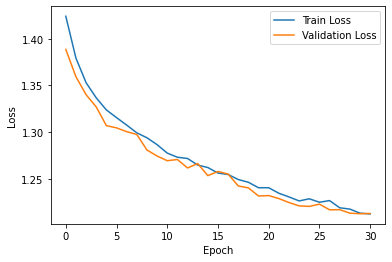

Improved result: acc 0.483, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=1)
epoch: 26
Epoch   0 | Train Loss: 1.427 | Train Acc:  36.64%
Epoch   0 | Val Loss: 1.384 | Val Acc:  38.77%
learning rate: [0.0008731864197530864]
Epoch   1 | Train Loss: 1.378 | Train Acc:  39.44%
Epoch   1 | Val Loss: 1.364 | Val Acc:  39.96%
learning rate: [0.0008120702866957328]
Epoch   2 | Train Loss: 1.357 | Train Acc:  40.51%
Epoch   2 | Val Loss: 1.334 | Val Acc:  41.53%
learning rate: [0.0007531760204081635]
Epoch   3 | Train Loss: 1.335 | Train Acc:  41.80%
Epoch   3 | Val Loss: 1.329 | Val Acc:  41.98%
learning rate: [0.0006965035817710718]
Epoch   4 | Train Loss: 1.325 | Train Acc:  42.24%
Epoch   4 | Val Loss: 1.308 | Val Acc:  42.71%
learning rate: [0.0006420529257067721]
Epoch   5 | Train Loss: 1.316 | Train Acc:  42.63%
Epoch   5 | Val Loss: 1.304 | Val Acc:  43.32%
learning rate: [0.0005898240000000002]
Epoch   6 | Train Loss: 1.310 | Trai

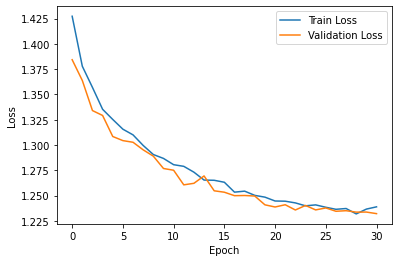

Epoch   0 | Train Loss: 1.428 | Train Acc:  35.87%
Epoch   0 | Val Loss: 1.386 | Val Acc:  38.46%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.378 | Train Acc:  39.35%
Epoch   1 | Val Loss: 1.358 | Val Acc:  40.29%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.354 | Train Acc:  40.34%
Epoch   2 | Val Loss: 1.338 | Val Acc:  41.54%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.335 | Train Acc:  41.66%
Epoch   3 | Val Loss: 1.324 | Val Acc:  42.11%
learning rate: [0.001]
Epoch   4 | Train Loss: 1.325 | Train Acc:  42.50%
Epoch   4 | Val Loss: 1.315 | Val Acc:  42.89%
learning rate: [0.001]
Epoch   5 | Train Loss: 1.319 | Train Acc:  42.71%
Epoch   5 | Val Loss: 1.306 | Val Acc:  42.89%
learning rate: [0.001]
Epoch   6 | Train Loss: 1.310 | Train Acc:  43.13%
Epoch   6 | Val Loss: 1.295 | Val Acc:  43.78%
learning rate: [0.001]
Epoch   7 | Train Loss: 1.298 | Train Acc:  43.77%
Epoch   7 | Val Loss: 1.289 | Val Acc:  44.08%
learning rate: [0.001]
Epoch   8 | Train Loss: 1.295 | 

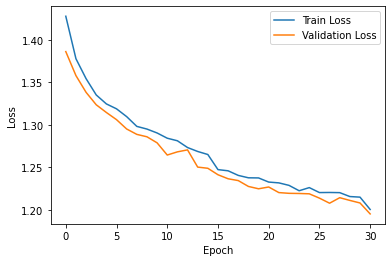

Improved result: acc 0.487, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=15, gamma=0.5)
epoch: 30
Epoch   0 | Train Loss: 1.424 | Train Acc:  36.71%
Epoch   0 | Val Loss: 1.384 | Val Acc:  38.62%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.377 | Train Acc:  39.31%
Epoch   1 | Val Loss: 1.354 | Val Acc:  40.58%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.355 | Train Acc:  40.25%
Epoch   2 | Val Loss: 1.336 | Val Acc:  41.73%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.337 | Train Acc:  41.52%
Epoch   3 | Val Loss: 1.322 | Val Acc:  42.22%
learning rate: [0.001]
Epoch   4 | Train Loss: 1.325 | Train Acc:  41.95%
Epoch   4 | Val Loss: 1.308 | Val Acc:  43.26%
learning rate: [0.001]
Epoch   5 | Train Loss: 1.316 | Train Acc:  42.83%
Epoch   5 | Val Loss: 1.315 | Val Acc:  42.27%
learning rate: [0.001]
Epoch   6 | Train Loss: 1.309 | Train Acc:  42.77%
Epoch   6 | Val Loss: 1.297 | Val Acc:  43.76%
learning rate: [0.001]
Epoch   7 | Train

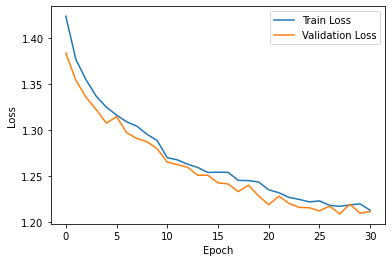

Epoch   0 | Train Loss: 1.425 | Train Acc:  36.72%
Epoch   0 | Val Loss: 1.390 | Val Acc:  38.53%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.379 | Train Acc:  39.14%
Epoch   1 | Val Loss: 1.365 | Val Acc:  40.07%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.354 | Train Acc:  40.35%
Epoch   2 | Val Loss: 1.340 | Val Acc:  41.60%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.341 | Train Acc:  41.31%
Epoch   3 | Val Loss: 1.321 | Val Acc:  42.23%
learning rate: [0.001]
Epoch   4 | Train Loss: 1.321 | Train Acc:  42.15%
Epoch   4 | Val Loss: 1.319 | Val Acc:  42.49%
learning rate: [0.001]
Epoch   5 | Train Loss: 1.316 | Train Acc:  42.17%
Epoch   5 | Val Loss: 1.320 | Val Acc:  42.14%
learning rate: [0.001]
Epoch   6 | Train Loss: 1.308 | Train Acc:  43.27%
Epoch   6 | Val Loss: 1.294 | Val Acc:  44.06%
learning rate: [0.00025]
Epoch   7 | Train Loss: 1.292 | Train Acc:  43.38%
Epoch   7 | Val Loss: 1.281 | Val Acc:  44.70%
learning rate: [0.0005]
Epoch   8 | Train Loss: 1.282

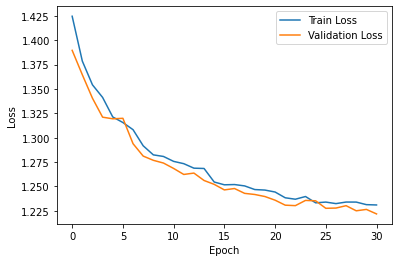

Epoch   0 | Train Loss: 1.424 | Train Acc:  36.72%
Epoch   0 | Val Loss: 1.383 | Val Acc:  39.40%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.377 | Train Acc:  39.24%
Epoch   1 | Val Loss: 1.359 | Val Acc:  40.37%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.351 | Train Acc:  40.74%
Epoch   2 | Val Loss: 1.338 | Val Acc:  41.69%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.337 | Train Acc:  41.91%
Epoch   3 | Val Loss: 1.325 | Val Acc:  42.21%
learning rate: [0.001]
Epoch   4 | Train Loss: 1.327 | Train Acc:  42.01%
Epoch   4 | Val Loss: 1.317 | Val Acc:  42.92%
learning rate: [0.001]
Epoch   5 | Train Loss: 1.317 | Train Acc:  42.41%
Epoch   5 | Val Loss: 1.311 | Val Acc:  42.76%
learning rate: [0.00025]
Epoch   6 | Train Loss: 1.301 | Train Acc:  43.81%
Epoch   6 | Val Loss: 1.296 | Val Acc:  43.96%
learning rate: [0.0005]
Epoch   7 | Train Loss: 1.292 | Train Acc:  43.99%
Epoch   7 | Val Loss: 1.292 | Val Acc:  43.88%
learning rate: [0.0005]
Epoch   8 | Train Loss: 1.29

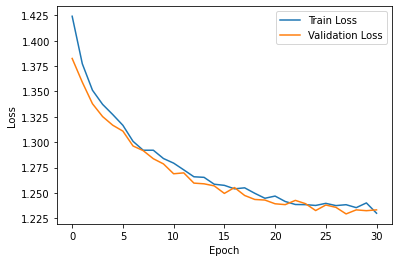

Epoch   0 | Train Loss: 1.425 | Train Acc:  36.61%
Epoch   0 | Val Loss: 1.384 | Val Acc:  38.88%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.380 | Train Acc:  38.95%
Epoch   1 | Val Loss: 1.358 | Val Acc:  40.08%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.353 | Train Acc:  40.78%
Epoch   2 | Val Loss: 1.342 | Val Acc:  41.05%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.336 | Train Acc:  41.24%
Epoch   3 | Val Loss: 1.332 | Val Acc:  41.39%
learning rate: [0.001]
Epoch   4 | Train Loss: 1.325 | Train Acc:  42.04%
Epoch   4 | Val Loss: 1.314 | Val Acc:  42.47%
learning rate: [0.00025]
Epoch   5 | Train Loss: 1.310 | Train Acc:  43.20%
Epoch   5 | Val Loss: 1.296 | Val Acc:  43.53%
learning rate: [0.0005]
Epoch   6 | Train Loss: 1.303 | Train Acc:  43.56%
Epoch   6 | Val Loss: 1.300 | Val Acc:  43.35%
learning rate: [0.0005]
Epoch   7 | Train Loss: 1.296 | Train Acc:  43.65%
Epoch   7 | Val Loss: 1.288 | Val Acc:  43.91%
learning rate: [0.0005]
Epoch   8 | Train Loss: 1.2

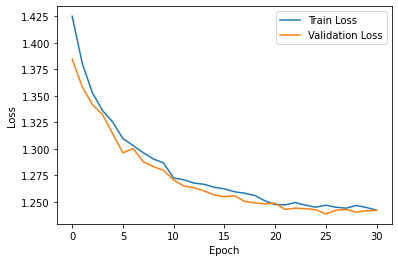

Epoch   0 | Train Loss: 1.426 | Train Acc:  36.29%
Epoch   0 | Val Loss: 1.387 | Val Acc:  38.88%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.377 | Train Acc:  39.35%
Epoch   1 | Val Loss: 1.361 | Val Acc:  40.28%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.352 | Train Acc:  40.60%
Epoch   2 | Val Loss: 1.332 | Val Acc:  42.10%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.337 | Train Acc:  41.63%
Epoch   3 | Val Loss: 1.324 | Val Acc:  42.13%
learning rate: [0.00025]
Epoch   4 | Train Loss: 1.317 | Train Acc:  42.74%
Epoch   4 | Val Loss: 1.316 | Val Acc:  42.71%
learning rate: [0.0005]
Epoch   5 | Train Loss: 1.312 | Train Acc:  42.47%
Epoch   5 | Val Loss: 1.301 | Val Acc:  43.63%
learning rate: [0.0005]
Epoch   6 | Train Loss: 1.307 | Train Acc:  43.31%
Epoch   6 | Val Loss: 1.294 | Val Acc:  43.67%
learning rate: [0.0005]
Epoch   7 | Train Loss: 1.300 | Train Acc:  43.55%
Epoch   7 | Val Loss: 1.289 | Val Acc:  44.10%
learning rate: [0.000125]
Epoch   8 | Train Loss: 

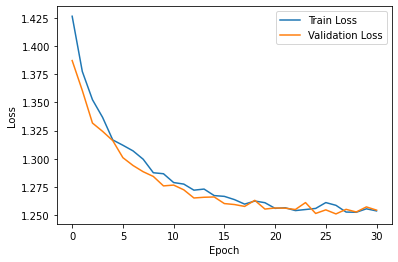

Epoch   0 | Train Loss: 1.429 | Train Acc:  36.21%
Epoch   0 | Val Loss: 1.385 | Val Acc:  38.58%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.379 | Train Acc:  38.97%
Epoch   1 | Val Loss: 1.361 | Val Acc:  40.19%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.355 | Train Acc:  39.99%
Epoch   2 | Val Loss: 1.338 | Val Acc:  41.63%
learning rate: [0.00025]
Epoch   3 | Train Loss: 1.329 | Train Acc:  41.76%
Epoch   3 | Val Loss: 1.320 | Val Acc:  42.55%
learning rate: [0.0005]
Epoch   4 | Train Loss: 1.321 | Train Acc:  42.31%
Epoch   4 | Val Loss: 1.310 | Val Acc:  42.59%
learning rate: [0.0005]
Epoch   5 | Train Loss: 1.315 | Train Acc:  42.57%
Epoch   5 | Val Loss: 1.304 | Val Acc:  43.53%
learning rate: [0.000125]
Epoch   6 | Train Loss: 1.306 | Train Acc:  43.20%
Epoch   6 | Val Loss: 1.298 | Val Acc:  43.55%
learning rate: [0.00025]
Epoch   7 | Train Loss: 1.296 | Train Acc:  43.51%
Epoch   7 | Val Loss: 1.291 | Val Acc:  44.16%
learning rate: [0.00025]
Epoch   8 | Train Los

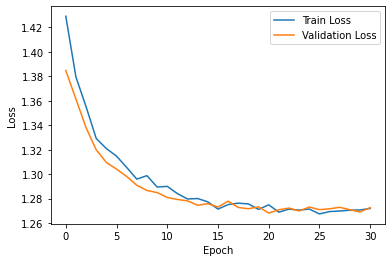

Epoch   0 | Train Loss: 1.422 | Train Acc:  36.35%
Epoch   0 | Val Loss: 1.392 | Val Acc:  38.36%
learning rate: [0.0009945348683780865]
Epoch   1 | Train Loss: 1.380 | Train Acc:  39.24%
Epoch   1 | Val Loss: 1.357 | Val Acc:  40.41%
learning rate: [0.0009809729126655758]
Epoch   2 | Train Loss: 1.359 | Train Acc:  39.75%
Epoch   2 | Val Loss: 1.340 | Val Acc:  41.07%
learning rate: [0.0009622060563219164]
Epoch   3 | Train Loss: 1.339 | Train Acc:  41.24%
Epoch   3 | Val Loss: 1.331 | Val Acc:  41.62%
learning rate: [0.0009384394159509803]
Epoch   4 | Train Loss: 1.326 | Train Acc:  42.29%
Epoch   4 | Val Loss: 1.317 | Val Acc:  42.76%
learning rate: [0.0009099328771543126]
Epoch   5 | Train Loss: 1.316 | Train Acc:  42.64%
Epoch   5 | Val Loss: 1.311 | Val Acc:  42.63%
learning rate: [0.0008769982411871534]
Epoch   6 | Train Loss: 1.309 | Train Acc:  43.09%
Epoch   6 | Val Loss: 1.301 | Val Acc:  42.96%
learning rate: [0.0008399958021800839]
Epoch   7 | Train Loss: 1.298 | Train Acc

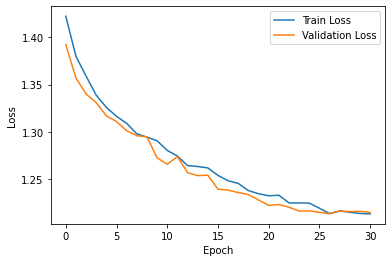

Epoch   0 | Train Loss: 1.424 | Train Acc:  36.85%
Epoch   0 | Val Loss: 1.381 | Val Acc:  39.14%
learning rate: [0.0009945299448360849]
Epoch   1 | Train Loss: 1.377 | Train Acc:  39.54%
Epoch   1 | Val Loss: 1.358 | Val Acc:  40.16%
learning rate: [0.0009809557711454547]
Epoch   2 | Train Loss: 1.351 | Train Acc:  40.76%
Epoch   2 | Val Loss: 1.338 | Val Acc:  41.58%
learning rate: [0.000962172007724008]
Epoch   3 | Train Loss: 1.336 | Train Acc:  41.42%
Epoch   3 | Val Loss: 1.322 | Val Acc:  42.47%
learning rate: [0.0009383839559653504]
Epoch   4 | Train Loss: 1.325 | Train Acc:  42.02%
Epoch   4 | Val Loss: 1.309 | Val Acc:  43.01%
learning rate: [0.0009098517356021992]
Epoch   5 | Train Loss: 1.317 | Train Acc:  42.51%
Epoch   5 | Val Loss: 1.305 | Val Acc:  43.21%
learning rate: [0.0008768874287918263]
Epoch   6 | Train Loss: 1.310 | Train Acc:  42.59%
Epoch   6 | Val Loss: 1.289 | Val Acc:  44.34%
learning rate: [0.0008398516542541199]
Epoch   7 | Train Loss: 1.300 | Train Acc:

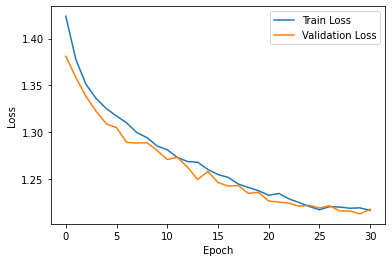

Epoch   0 | Train Loss: 1.424 | Train Acc:  36.37%
Epoch   0 | Val Loss: 1.387 | Val Acc:  38.29%
learning rate: [0.0009945294524818845]
Epoch   1 | Train Loss: 1.382 | Train Acc:  38.81%
Epoch   1 | Val Loss: 1.359 | Val Acc:  39.99%
learning rate: [0.0009809540569934423]
Epoch   2 | Train Loss: 1.353 | Train Acc:  40.15%
Epoch   2 | Val Loss: 1.342 | Val Acc:  41.61%
learning rate: [0.000962168602864217]
Epoch   3 | Train Loss: 1.337 | Train Acc:  41.41%
Epoch   3 | Val Loss: 1.327 | Val Acc:  42.27%
learning rate: [0.0009383784099667872]
Epoch   4 | Train Loss: 1.328 | Train Acc:  41.72%
Epoch   4 | Val Loss: 1.321 | Val Acc:  42.45%
learning rate: [0.0009098436214469878]
Epoch   5 | Train Loss: 1.317 | Train Acc:  42.79%
Epoch   5 | Val Loss: 1.299 | Val Acc:  44.01%
learning rate: [0.0008768763475522935]
Epoch   6 | Train Loss: 1.304 | Train Acc:  43.39%
Epoch   6 | Val Loss: 1.305 | Val Acc:  42.87%
learning rate: [0.0008398372394615234]
Epoch   7 | Train Loss: 1.301 | Train Acc:

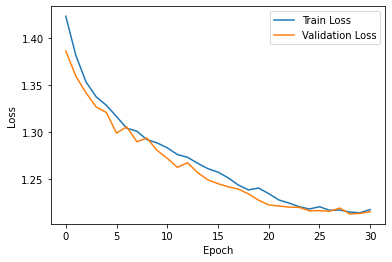

Epoch   0 | Train Loss: 1.602 | Train Acc:  26.77%
Epoch   0 | Val Loss: 1.535 | Val Acc:  30.74%
learning rate: [4.013191114728837e-05]
Epoch   1 | Train Loss: 1.505 | Train Acc:  32.05%
Epoch   1 | Val Loss: 1.478 | Val Acc:  33.69%
learning rate: [4.052757208685852e-05]
Epoch   2 | Train Loss: 1.460 | Train Acc:  34.54%
Epoch   2 | Val Loss: 1.445 | Val Acc:  35.49%
learning rate: [4.118676535167507e-05]
Epoch   3 | Train Loss: 1.434 | Train Acc:  36.21%
Epoch   3 | Val Loss: 1.422 | Val Acc:  37.03%
learning rate: [4.210912862948892e-05]
Epoch   4 | Train Loss: 1.418 | Train Acc:  37.01%
Epoch   4 | Val Loss: 1.409 | Val Acc:  37.82%
learning rate: [4.329415496197395e-05]
Epoch   5 | Train Loss: 1.407 | Train Acc:  37.60%
Epoch   5 | Val Loss: 1.402 | Val Acc:  38.26%
learning rate: [4.474119302336763e-05]
Epoch   6 | Train Loss: 1.398 | Train Acc:  38.29%
Epoch   6 | Val Loss: 1.396 | Val Acc:  38.10%
learning rate: [4.6449447478457665e-05]
Epoch   7 | Train Loss: 1.392 | Train Ac

In [ ]:
trained_gcn = hyperparameter_tuning(model_gcn, strat_train, strat_val, scheduler_list)

In [52]:
model_gat = GAT(cv19_graph_data_train.num_node_features, 
                10, 5, 10).to(device)
print(model_gat)

GAT(
  (gat_list): ModuleList(
    (0-9): 10 x GATv2Conv(50, 25, heads=10)
  )
  (softmax): Softmax(dim=1)
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=250, out_features=1, bias=True)
  )
  (bn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


In [53]:
print(get_lr(model_gcn.optimizer))
scheduler_list = build_scheduler_list()
print(scheduler_list)

0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=1), functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=15, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=10, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=7, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=6, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=5, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=4, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=3, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=30, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=30, eta_min=1e-07), functoo

Epoch   0 | Train Loss: 1.369 | Train Acc:  39.95%
Epoch   0 | Val Loss: 1.305 | Val Acc:  42.95%
learning rate: [0.0009344444444444444]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:749: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch   1 | Train Loss: 1.264 | Train Acc:  45.28%
Epoch   1 | Val Loss: 1.214 | Val Acc:  47.96%
learning rate: [0.0009011494252873565]
Epoch   2 | Train Loss: 1.202 | Train Acc:  48.54%
Epoch   2 | Val Loss: 1.167 | Val Acc:  49.98%
learning rate: [0.000867857142857143]
Epoch   3 | Train Loss: 1.164 | Train Acc:  50.56%
Epoch   3 | Val Loss: 1.123 | Val Acc:  52.68%
learning rate: [0.0008345679012345681]
Epoch   4 | Train Loss: 1.131 | Train Acc:  52.22%
Epoch   4 | Val Loss: 1.095 | Val Acc:  53.73%
learning rate: [0.0008012820512820515]
Epoch   5 | Train Loss: 1.103 | Train Acc:  53.58%
Epoch   5 | Val Loss: 1.075 | Val Acc:  55.07%
learning rate: [0.0007680000000000001]
Epoch   6 | Train Loss: 1.078 | Train Acc:  54.74%
Epoch   6 | Val Loss: 1.050 | Val Acc:  56.47%
learning rate: [0.0007347222222222223]
Epoch   7 | Train Loss: 1.062 | Train Acc:  55.38%
Epoch   7 | Val Loss: 1.044 | Val Acc:  56.81%
learning rate: [0.0007014492753623191]
Epoch   8 | Train Loss: 1.042 | Train Acc:

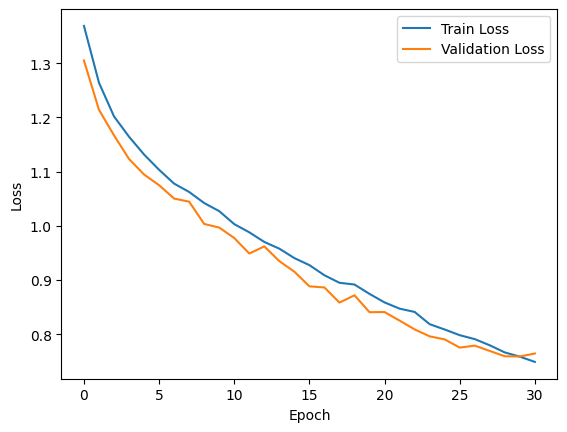

Improved result: acc 0.709, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=1)
epoch: 28
Epoch   0 | Train Loss: 1.370 | Train Acc:  39.69%
Epoch   0 | Val Loss: 1.291 | Val Acc:  44.31%
learning rate: [0.0008731864197530864]
Epoch   1 | Train Loss: 1.268 | Train Acc:  45.15%
Epoch   1 | Val Loss: 1.225 | Val Acc:  47.42%
learning rate: [0.0008120702866957328]
Epoch   2 | Train Loss: 1.205 | Train Acc:  48.27%
Epoch   2 | Val Loss: 1.165 | Val Acc:  50.59%
learning rate: [0.0007531760204081635]
Epoch   3 | Train Loss: 1.164 | Train Acc:  50.45%
Epoch   3 | Val Loss: 1.125 | Val Acc:  52.23%
learning rate: [0.0006965035817710718]
Epoch   4 | Train Loss: 1.132 | Train Acc:  52.02%
Epoch   4 | Val Loss: 1.091 | Val Acc:  54.17%
learning rate: [0.0006420529257067721]
Epoch   5 | Train Loss: 1.105 | Train Acc:  53.57%
Epoch   5 | Val Loss: 1.071 | Val Acc:  55.23%
learning rate: [0.0005898240000000002]
Epoch   6 | Train Loss: 1.078 | Trai

In [ ]:
trained_gat = hyperparameter_tuning(model_gat, strat_train, strat_val, scheduler_list)

In [ ]:
# the worst loss that we can have is:
worst_loss = - np.log(1/cv19_graph_data_train.num_classes)
print(worst_loss)

1.6094379124341003
